In [200]:
from Bio.PDB import *
import numpy as np
import os

## Read reference (test) pdb file and create reference (test) contact map

Define a simple function which returns the distance between two alpha carbon atoms, and a second function which uses this to calculate an entire distance matrix:

In [201]:
def calc_residue_dist(amino_acid_one, amino_acid_two):
    """Returns the C-alpha distance between two residues"""
    diff_vector  = amino_acid_one["CA"].coord - amino_acid_two["CA"].coord
    return np.sqrt(np.sum(diff_vector * diff_vector))

def calc_dist_matrix(chain):
    """Returns a matrix of C-alpha distances"""
    answer = np.zeros((len(chain), len(chain)), np.float64)
    for row, amino_acid_one in enumerate(chain):
        for col, amino_acid_two in enumerate(chain):
            answer[row, col] = calc_residue_dist(amino_acid_one, amino_acid_two)
    return answer

Then the reference PDB file is read into the variable structure using Bio.PDB.PDBParser()

In [202]:
pdb_code = "test"
pdb_filename = "tetR.pdb"

In [203]:
test_model = PDBParser().get_structure(pdb_code, pdb_filename)[0]

/home/maksym/anaconda3/lib/python3.8/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 709
  warnings.warn(


### Calculate the distance matrix to get reference (test) contact map

In [204]:
dist_threshold = 9
for chain in test_model:
    dist_matrix = calc_dist_matrix(chain)
    test_contact_map = dist_matrix < dist_threshold
    test_contact_map = test_contact_map.astype(np.int32)
    break

In [205]:
test_contact_map.shape

(44, 44)

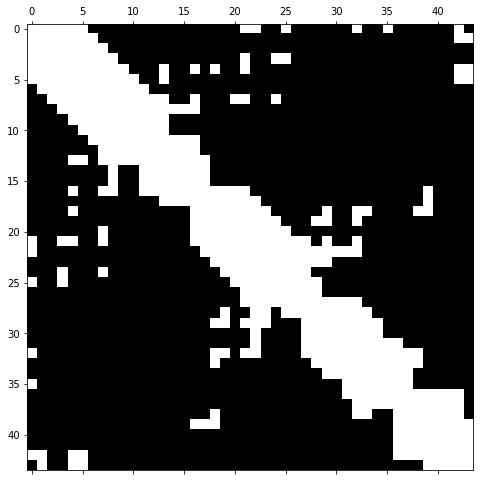

In [206]:
import matplotlib.pyplot as plt

plt.figure(figsize=[8, 8])
plt.matshow(test_contact_map, fignum=1, cmap='gray')

## Load and deal with Mutual Information table

Load npy file. It was created in PredProtStruct.ipynb

In [207]:
train_mi_table = np.load("mi_table_corrected2.npy")

In [208]:
train_mi_table.min(), train_mi_table.max()

(-0.18121055825612498, 2.4184813812748183)

In [209]:
def mi_to_contact_map(mi_table, threshold): #convert mutual information table to contact map using threshold
    train_contact_map = mi_table > threshold
    train_contact_map = train_contact_map.astype(np.int32)
    return train_contact_map

### Matrix similarity metrics

In [210]:
def matrix_dist(m1, m2): #metric 1: Matrix difference norm
    #assert m1.shape == m2.shape
    matrix_diff = m1 - m2
    return np.linalg.norm(matrix_diff)

def equal_zeros(m1, m2): #metric 2: Zeros quantity difference
    _, counts1 = np.unique(m1, return_counts=True)
    _, counts2 = np.unique(m2, return_counts=True)
    return np.abs(counts1[0] - counts2[0])

In [211]:
def threshold_func(test_contact_map, train_mi_table, threshold, func):
    train_contact_map = mi_to_contact_map(train_mi_table, threshold)
    return func(train_contact_map, test_contact_map)

### Find the threshold by minimizing one of the metrics

It is possible to use non gradient optimization (for example basin-hopping algorithm) to minimize threshold but we don't need it. We can just check every threshold from min(train_mi_table) to max(train_mi_table) with small step

In [212]:
min_y = 11111111
threshold = -1
i = 0.1
for i in np.linspace(train_mi_table.min(), train_mi_table.max() + 1e-10, 100000):
    func_y = threshold_func(test_contact_map, train_mi_table, i, matrix_dist)
    if func_y < min_y:
        min_y = func_y
        threshold = i

#0.01874, 0.03255
#0.07175717571757176, 0.03255032550325503

In [213]:
threshold, min_y

(0.07631750056430447, 21.400934559032695)

## Create PDB file

In [217]:
import os

In [218]:
contact_map = mi_to_contact_map(train_mi_table, threshold)

fd = open("my_contacts.lst", "w")
fd.write(str(contact_map.shape[1]) + '\n')
for val in contact_map.reshape(-1):
    fd.write(str(val) + '\n')

FT-COMAR is not a strict converter, so we call it multiple times

In [219]:
for i in range(0, 5):
    os.system(f"ft-comar/FT-COMAR my_contacts.lst 9 0 train{i}.pdb")

chain 1 er 220 time 0.38 erS 220 chain 1 er 211 time 0.38 erS 211 chain 1 er 211 time 0.36 erS 211 chain 1 er 191 time 0.34 erS 191 chain 1 er 191 time 0.34 erS 191 

# Another method for measuring protein similarity

We should get similar 3d structures. So we can compare train and test protein structure coordinates (of the carbon acids) and find the closest train structure.

In [220]:
def get_coords(model): #pdb parser model -> np.array with CA coordinates
    model_coords = []
    for chain in model:
        for amino_acid in chain:
            model_coords.append(amino_acid["CA"].coord)
    
    return np.array(model_coords)

In [221]:
def coords_from_pdb(file_name):
    model_coords = []

    fd = open(file_name, "r")
    for val in fd:
        x1 = float(val[30:38])
        x2 = float(val[38:46])
        x3 = float(val[46:54]) 
        model_coords.append([x1, x2, x3])
        
    fd.close()
    return np.array(model_coords)

metric 1: displacement of structures to one center of mass and coordinate difference norm

   we are not sure if the centers of mass are in the same places, so we need to conduct an experiment

In [222]:
def _set_equal_norm(coords_to_move, coords_const):
    mean1 = np.mean(coords_const, axis=0)
    mean2 = np.mean(coords_to_move, axis=0)

    return coords_to_move - mean2 + mean1

def diff_exclude_bias(train_struct, test_struct): # metric 1: displacement of structures to one center of mass and coordinate difference norm
    diff_matrix = train_struct - _set_equal_norm(test_struct, train_struct)
    diff_points = np.sqrt(np.sum(diff_matrix * diff_matrix, axis = 1))
    return np.sqrt(np.sum(diff_points * diff_points))

metric 2: coordinate difference norm

In [223]:
def diff_norm(train_struct, test_struct): #metric 2: coordinate difference norm
    diff_matrix = train_struct - test_struct
    diff_points = np.sqrt(np.sum(diff_matrix * diff_matrix, axis = 1))
    return np.sqrt(np.sum(diff_points * diff_points))

metric 3: center mass bias

In [224]:
def struct_bias(coords_to_move, coords_const): #metric 3: center mass bias
    mean1 = np.mean(coords_const, axis=0)
    mean2 = np.mean(coords_to_move, axis=0)

    return np.sqrt(np.sum((mean1 - mean2)**2))

Calculate the distance between train and test structure using one of the metrics

In [225]:
def struct_dist(train_contact_map, test_model, dist_func):
    train_contact_map_size = train_contact_map.shape[1]

    fd = open("my_contacts.lst", "w")
    fd.write(str(train_contact_map_size) + '\n')
    for val in train_contact_map.reshape(-1):
        fd.write(str(val) + '\n')
    fd.close()

    pdb_filename = "tmp_file.pdb"
    train_struct = coords_from_pdb(pdb_filename)
    test_struct  = get_coords(test_model)
    return dist_func(train_struct, test_struct)


In [226]:
def get_dist(train_mi_table, test_model, threshold, dist_func):
    train_contact_map = mi_to_contact_map(train_mi_table, threshold)
    return struct_dist(train_contact_map, test_model, dist_func)

Load test structure. Load mutual information matrix (from PredProdStruct.ipynb)

In [227]:
test_model = PDBParser().get_structure("test", "tetR.pdb")[0]
train_mi_table = np.load("mi_table_corrected2.npy")

/home/maksym/anaconda3/lib/python3.8/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 709
  warnings.warn(


### Find the threshold by minimizing one of the metrics

In [228]:
min_y = 11111111
threshold = -1
for i in np.linspace(train_mi_table.min(), train_mi_table.max() + 1e-10, 1000):
    func_y = get_dist(train_mi_table, test_model, i, diff_norm)
    if func_y < min_y:
        min_y = func_y
        threshold = i

In [229]:
threshold, min_y

(-0.18121055825612498, 193.29036694853482)

## Other options (finaly unused)

### Find the global minimum of a function using the basin-hopping algorithm

In [ ]:
from scipy.optimize import basinhopping
from scipy.optimize import minimize

In [ ]:
minimizer_kwargs = {"method": "BFGS"}
func = lambda x: threshold_func(test_contact_map, train_mi_table, x, matrix_dist)
x0 = 0.3
ret = basinhopping(func, x0, #minimizer_kwargs=minimizer_kwargs,
                   niter=200)

print("global minimum: x = %.4f, f(x) = %.4f" % (ret.x, ret.fun))

global minimum: x = 0.0786, f(x) = 21.4009


In [ ]:
func = lambda x: threshold_func(test_contact_map, train_mi_table, x, equal_zeros)
x0 = 0.2
ret = minimize(func, x0, method="Nelder-Mead")
print("global minimum: x = %.4f, f(x) = %.4f" % (ret.x, ret.fun))

global minimum: x = 0.1900, f(x) = 461.0000
